In this notebook we are going to explore the Cox Proportional Hazard Regression model. It computes the survival probability and the hazard probability for each individual in the population considered for the analysis. We are going thus to obtain indications specifically for each customer, and not a general indication computed on the average value for the survival probability, as it happens with the Kaplan-Meier estimator.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.util import Surv
from sksurv.metrics import concordance_index_censored

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import set_config
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [35]:
def download_dataset(url):
    d = pd.read_csv(url) # POTENTIALLY: apply parse_dates, based on the dataset format
    ids = d.id
    d.drop(['id'], axis = 1, inplace = True)
    print(d.info(show_counts = True))
    return d, ids

In [36]:
train, _ = download_dataset("train.csv")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CustomerId       165034 non-null  int64  
 1   Surname          165034 non-null  object 
 2   CreditScore      165034 non-null  int64  
 3   Geography        165034 non-null  object 
 4   Gender           165034 non-null  object 
 5   Age              165034 non-null  float64
 6   Tenure           165034 non-null  int64  
 7   Balance          165034 non-null  float64
 8   NumOfProducts    165034 non-null  int64  
 9   HasCrCard        165034 non-null  float64
 10  IsActiveMember   165034 non-null  float64
 11  EstimatedSalary  165034 non-null  float64
 12  Exited           165034 non-null  int64  
dtypes: float64(5), int64(5), object(3)
memory usage: 16.4+ MB
None


In [37]:
def categorical_handling(categories, names, df):
    for c, n in zip(categories, names):
        ohe = LabelEncoder() #OneHotEncoder(sparse_output = False)
        encs = ohe.fit_transform(df[[c]])
        encs_df = pd.DataFrame(encs)
        cols = []
        cols.append(n)
        encs_df.columns = cols
        df.drop(c, axis = 1, inplace = True)
        df = pd.concat([df, encs_df], axis = 1)
        #df.drop(c, axis = 1, inplace = True)
    return df

In [38]:
catv = ['Geography', 'Gender'] #, 'IsActiveMember', 'HasCrCard', 'NumOfProducts']
names = ['Geography', 'Gender'] #, 'Act', 'Cred', 'Prod']
train = categorical_handling(catv, names, train)

/nfs/home/medoro/Churn-detection/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/nfs/home/medoro/Churn-detection/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [39]:
set_config(display="Text")

In [40]:
train.drop(['CustomerId', 'Surname'], axis = 1, inplace = True)

In [41]:
train

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography,Gender
0,668,33.0,3,0.00,2,1.0,0.0,181449.97,0,0,1
1,627,33.0,1,0.00,2,1.0,1.0,49503.50,0,0,1
2,678,40.0,10,0.00,2,1.0,0.0,184866.69,0,0,1
3,581,34.0,2,148882.54,1,1.0,1.0,84560.88,0,0,1
4,716,33.0,5,0.00,2,1.0,1.0,15068.83,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...
165029,667,33.0,2,0.00,1,1.0,1.0,131834.75,0,2,0
165030,792,35.0,3,0.00,1,0.0,0.0,131834.45,0,0,1
165031,565,31.0,5,0.00,1,1.0,1.0,127429.56,0,0,1
165032,554,30.0,7,161533.00,1,0.0,1.0,71173.03,0,2,0


In [42]:
X = train.drop(['Exited', "Tenure"], axis=1)
y = train[['Exited', "Tenure"]]
y['Exited'] = y['Exited'].astype(bool)
y = Surv.from_dataframe('Exited', "Tenure", y)

/tmp/ipykernel_804908/4101400879.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['Exited'] = y['Exited'].astype(bool)


In [43]:
cph = CoxPHSurvivalAnalysis()
cph.fit(X, y)

CoxPHSurvivalAnalysis()

In [44]:
pd.Series(cph.coef_, index = X.columns)

CreditScore       -4.067448e-04
Age                5.603701e-02
Balance            1.509865e-06
NumOfProducts     -5.600367e-01
HasCrCard         -9.095236e-02
IsActiveMember    -8.446999e-01
EstimatedSalary    6.374045e-07
Geography          7.285023e-02
Gender            -4.352574e-01
dtype: float64

In [45]:
prediction = cph.predict(X)
result = concordance_index_censored(y["Exited"], y["Tenure"], prediction)
result[0]

np.float64(0.7525831525608675)

In [46]:
cph.score(X, y)

np.float64(0.7525831525608675)

In [47]:
# FUNCTION TAKEN FROM SCIKIT-SURVIVAL DOCUMENTATION
def fit_and_score_features(X, y):
    n_features = X.shape[1] # Take the number of features
    scores = np.empty(n_features) # For each feature we are going to compute a score
    m = CoxPHSurvivalAnalysis()
    for j in range(n_features):
        Xj = X[:, j : j + 1] # Select each feature alone
        m.fit(Xj, y) # Fit the model by considering the selected feature
        scores[j] = m.score(Xj, y) # Compute the C-index score
    return scores


scores = fit_and_score_features(X.values, y)
pd.Series(scores, index=X.columns).sort_values(ascending=False)

Age                0.708238
NumOfProducts      0.636053
IsActiveMember     0.603406
Gender             0.574503
Balance            0.568995
Geography          0.542389
CreditScore        0.515709
HasCrCard          0.510845
EstimatedSalary    0.510322
dtype: float64

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41)

In [49]:
y_train

array([(False, 1.), (False, 6.), (False, 8.), ..., (False, 6.),
       (False, 4.), (False, 3.)],
      dtype=[('Exited', '?'), ('Tenure', '<f8')])

In [50]:
y_test

array([( True, 2.), (False, 6.), ( True, 1.), ..., (False, 6.),
       ( True, 1.), (False, 3.)],
      dtype=[('Exited', '?'), ('Tenure', '<f8')])

In [51]:
cph = CoxPHSurvivalAnalysis()
cph.fit(X_train, y_train)

CoxPHSurvivalAnalysis()

In [52]:
risk = cph.predict(X_train)
risk

array([ 0.98665226,  1.62086823, -0.17169149, ...,  0.37139531,
       -0.15106597, -0.6374424 ])

In [53]:
risk = cph.predict(X_test)
risk

array([-0.51722887,  0.6457139 ,  1.78326118, ...,  0.60642485,
        1.7462686 ,  1.2279282 ])

In [54]:
cum_hazard = cph.predict_cumulative_hazard_function(X_test, return_array=True)
cum_hazard

array([[0.00205613, 0.00839537, 0.01494103, ..., 0.09395412, 0.13491636,
        0.18971943],
       [0.00657825, 0.0268596 , 0.04780137, ..., 0.30059063, 0.43164254,
        0.60697587],
       [0.02051827, 0.083778  , 0.14909766, ..., 0.93757484, 1.34633998,
        1.8932237 ],
       ...,
       [0.00632481, 0.02582477, 0.04595971, ..., 0.2890097 , 0.41501254,
        0.58359076],
       [0.01977312, 0.08073546, 0.14368292, ..., 0.90352521, 1.29744534,
        1.82446804],
       [0.01177505, 0.04807862, 0.08556433, ..., 0.53805652, 0.77263912,
        1.08648538]])

In [55]:
df_hazard = pd.DataFrame(cum_hazard).T
df_hazard

,0,1,2,3,4,5,6,7,8,9,...,32997,32998,32999,33000,33001,33002,33003,33004,33005,33006
0,0.002056,0.006578,0.020518,0.002745,0.002387,0.004130,0.006313,0.004142,0.003235,0.007849,...,0.003031,0.001346,0.009273,0.007605,0.001512,0.012447,0.001380,0.006325,0.019773,0.011775
1,0.008395,0.026860,0.083778,0.011209,0.009746,0.016861,0.025779,0.016913,0.013207,0.032048,...,0.012377,0.005495,0.037862,0.031052,0.006173,0.050822,0.005635,0.025825,0.080735,0.048079
2,0.014941,0.047801,0.149098,0.019948,0.017345,0.030008,0.045877,0.030099,0.023505,0.057036,...,0.022026,0.009780,0.067382,0.055263,0.010986,0.090446,0.010029,0.045960,0.143683,0.085564
3,0.023032,0.073687,0.229837,0.030750,0.026738,0.046257,0.070721,0.046398,0.036233,0.087921,...,0.033954,0.015076,0.103870,0.085189,0.016936,0.139424,0.015459,0.070848,0.221490,0.131899
4,0.032739,0.104743,0.326704,0.043710,0.038007,0.065753,0.100527,0.065953,0.051504,0.124977,...,0.048264,0.021429,0.147647,0.121093,0.024074,0.198186,0.021975,0.100707,0.314839,0.187489
5,0.043811,0.140166,0.437193,0.058493,0.050860,0.087990,0.134524,0.088258,0.068922,0.167243,...,0.064587,0.028676,0.197580,0.162045,0.032215,0.265211,0.029406,0.134766,0.421315,0.250897
6,0.055361,0.177119,0.552455,0.073914,0.064269,0.111188,0.169991,0.111527,0.087093,0.211335,...,0.081615,0.036237,0.249670,0.204767,0.040708,0.335131,0.037159,0.170296,0.532392,0.317043
7,0.070876,0.226757,0.707280,0.094628,0.082280,0.142348,0.217630,0.142782,0.111501,0.270562,...,0.104487,0.046392,0.319640,0.262153,0.052117,0.429052,0.047573,0.218021,0.681594,0.405895
8,0.093954,0.300591,0.937575,0.125440,0.109071,0.188698,0.288492,0.189273,0.147806,0.358658,...,0.138509,0.061498,0.423717,0.347512,0.069086,0.568754,0.063063,0.289010,0.903525,0.538057
9,0.134916,0.431643,1.346340,0.180129,0.156624,0.270966,0.414269,0.271792,0.212247,0.515026,...,0.198896,0.088309,0.608450,0.499021,0.099207,0.816720,0.090557,0.415013,1.297445,0.772639


In [56]:
surv_func = cph.predict_survival_function(X_test, return_array = True)
surv_func

array([[0.99794598, 0.99163977, 0.98517003, ..., 0.91032453, 0.87378899,
        0.82719119],
       [0.99344334, 0.97349791, 0.95332313, ..., 0.7403808 , 0.64944149,
        0.54499652],
       [0.97969079, 0.91963539, 0.86148498, ..., 0.39157632, 0.26019082,
        0.15058558],
       ...,
       [0.99369515, 0.97450584, 0.95508044, ..., 0.74900494, 0.660332  ,
        0.55789151],
       [0.98042109, 0.92243768, 0.86616235, ..., 0.40513894, 0.27322891,
        0.16130343],
       [0.988294  , 0.95305886, 0.91799408, ..., 0.58388191, 0.46179273,
        0.33740025]])

In [57]:
df_surv = pd.DataFrame(surv_func).T
df_surv

,0,1,2,3,4,5,6,7,8,9,...,32997,32998,32999,33000,33001,33002,33003,33004,33005,33006
0,0.997946,0.993443,0.979691,0.997259,0.997616,0.995879,0.993706,0.995866,0.996771,0.992182,...,0.996973,0.998655,0.990770,0.992424,0.998489,0.987630,0.998621,0.993695,0.980421,0.988294
1,0.991640,0.973498,0.919635,0.988854,0.990301,0.983280,0.974551,0.983230,0.986879,0.968460,...,0.987700,0.994520,0.962846,0.969425,0.993846,0.950448,0.994381,0.974506,0.922438,0.953059
2,0.985170,0.953323,0.861485,0.980250,0.982805,0.970438,0.955159,0.970349,0.976769,0.944560,...,0.978214,0.990268,0.934838,0.946236,0.989074,0.913524,0.990022,0.955080,0.866162,0.917994
3,0.977231,0.928963,0.794663,0.969718,0.973617,0.954796,0.931722,0.954662,0.964415,0.915833,...,0.966616,0.985038,0.901342,0.918339,0.983207,0.869859,0.984660,0.931604,0.801324,0.876429
4,0.967791,0.900556,0.721297,0.957231,0.962707,0.936362,0.904361,0.936175,0.949800,0.882517,...,0.952882,0.978799,0.862736,0.885952,0.976214,0.820217,0.978265,0.904198,0.729906,0.829038
5,0.957135,0.869214,0.645847,0.943185,0.950412,0.915770,0.874132,0.915524,0.933399,0.845994,...,0.937455,0.971731,0.820715,0.850403,0.968298,0.767044,0.971022,0.873921,0.656183,0.778103
6,0.946143,0.837680,0.575535,0.928752,0.937753,0.894771,0.843673,0.894467,0.916592,0.809503,...,0.921627,0.964412,0.779058,0.814837,0.960109,0.715244,0.963523,0.843415,0.587199,0.728299
7,0.931577,0.797114,0.492983,0.909711,0.921014,0.867319,0.804423,0.866943,0.894491,0.762951,...,0.900786,0.954668,0.726410,0.769393,0.949218,0.651126,0.953541,0.804109,0.505810,0.666380
8,0.910325,0.740381,0.391576,0.882109,0.896666,0.828037,0.749393,0.827561,0.862598,0.698613,...,0.870655,0.940355,0.654609,0.706444,0.933246,0.566231,0.938884,0.749005,0.405139,0.583882
9,0.873789,0.649441,0.260191,0.835162,0.855025,0.762642,0.660823,0.762013,0.808765,0.597485,...,0.819635,0.915478,0.544194,0.607125,0.905555,0.441879,0.913422,0.660332,0.273229,0.461793


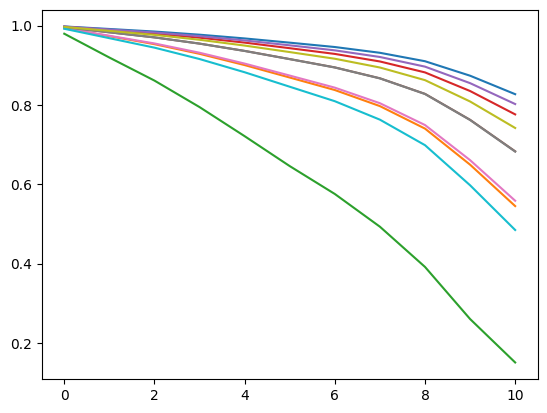

In [58]:
plt.plot(df_surv.iloc[:, :10])
plt.show()

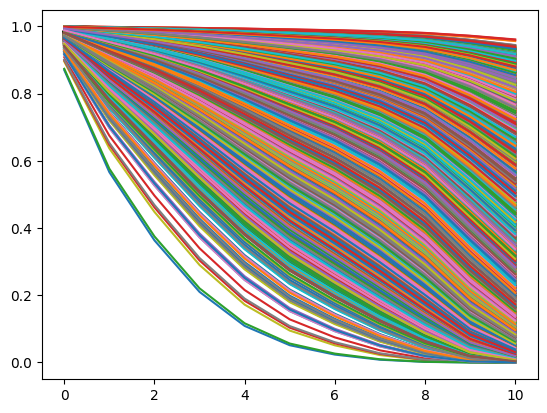

In [59]:
plt.plot(df_surv)
plt.show()

In [60]:
predicted_time_to_churn = df_surv[df_surv <= 0.5]
churns = predicted_time_to_churn.apply(lambda col: col.first_valid_index())

In [61]:
X_test = X_test.reset_index()

In [62]:
X_test

,index,CreditScore,Age,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography,Gender
0,77006,715,31.0,0.00,2,1.0,1.0,143204.41,0,0
1,32268,656,29.0,137964.51,1,1.0,0.0,64443.75,2,1
2,117133,545,55.0,133676.65,1,0.0,1.0,17095.49,2,0
3,157989,625,33.0,0.00,1,1.0,1.0,157932.75,0,1
4,129796,708,39.0,0.00,2,1.0,1.0,143030.09,2,1
...,...,...,...,...,...,...,...,...,...,...
33002,103340,602,42.0,98362.35,2,0.0,0.0,152843.53,1,0
33003,114045,506,37.0,125843.66,3,1.0,1.0,54865.41,1,1
33004,122823,751,44.0,132088.57,1,1.0,1.0,179834.95,1,1
33005,152822,721,52.0,0.00,1,0.0,0.0,192013.23,0,1


In [63]:
X_test['time_to_churn'] = churns
1-(X_test.time_to_churn.isna().sum()/len(X_test))

np.float64(0.33486836125670316)

In [64]:
X_test

,index,CreditScore,Age,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography,Gender,time_to_churn
0,77006,715,31.0,0.00,2,1.0,1.0,143204.41,0,0,NaN
1,32268,656,29.0,137964.51,1,1.0,0.0,64443.75,2,1,NaN
2,117133,545,55.0,133676.65,1,0.0,1.0,17095.49,2,0,7.0
3,157989,625,33.0,0.00,1,1.0,1.0,157932.75,0,1,NaN
4,129796,708,39.0,0.00,2,1.0,1.0,143030.09,2,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...
33002,103340,602,42.0,98362.35,2,0.0,0.0,152843.53,1,0,9.0
33003,114045,506,37.0,125843.66,3,1.0,1.0,54865.41,1,1,NaN
33004,122823,751,44.0,132088.57,1,1.0,1.0,179834.95,1,1,NaN
33005,152822,721,52.0,0.00,1,0.0,0.0,192013.23,0,1,8.0


In [65]:
X_test = X_test.fillna(11)

In [66]:
gt = pd.DataFrame.from_records(y_test)
gt

,Exited,Tenure
0,True,2.0
1,False,6.0
2,True,1.0
3,False,8.0
4,False,9.0
...,...,...
33002,False,7.0
33003,True,8.0
33004,False,6.0
33005,True,1.0


In [67]:
new_test = pd.concat([X_test, gt], axis = 1)
new_test

,index,CreditScore,Age,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography,Gender,time_to_churn,Exited,Tenure
0,77006,715,31.0,0.00,2,1.0,1.0,143204.41,0,0,11.0,True,2.0
1,32268,656,29.0,137964.51,1,1.0,0.0,64443.75,2,1,11.0,False,6.0
2,117133,545,55.0,133676.65,1,0.0,1.0,17095.49,2,0,7.0,True,1.0
3,157989,625,33.0,0.00,1,1.0,1.0,157932.75,0,1,11.0,False,8.0
4,129796,708,39.0,0.00,2,1.0,1.0,143030.09,2,1,11.0,False,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
33002,103340,602,42.0,98362.35,2,0.0,0.0,152843.53,1,0,9.0,False,7.0
33003,114045,506,37.0,125843.66,3,1.0,1.0,54865.41,1,1,11.0,True,8.0
33004,122823,751,44.0,132088.57,1,1.0,1.0,179834.95,1,1,11.0,False,6.0
33005,152822,721,52.0,0.00,1,0.0,0.0,192013.23,0,1,8.0,True,1.0


In [68]:
new_test['diff_time_to_churn'] = new_test['time_to_churn'] - new_test.Tenure
# Compute the difference between the time to churn predicted and the actual tenure
new_test['early_detection'] = [1 if x > 0  else 0 for x in new_test.diff_time_to_churn]
# Let's see if potentially the model performed an early detection, just based on whether the difference is positive
# or negative
print(new_test.Exited.sum()/len(new_test))
# Now we want to undersand which are the labels that the model would associate based on the survival probabilities computed
# To do so: let's define that:
# - all with time to churn > 11 are automatically considered as non-churn individuals
# - for the rest, we are going to consider them as churn individuals, given that the model indicated that they
#   churn within the time frame taken as reference for the analysis (so from year 0 to 10 in this case)
new_test['labels_to_churn'] = [1 if x < 10 else 0 for x in new_test.time_to_churn]
print(new_test.labels_to_churn.sum()/len(new_test))
print(classification_report(new_test.Exited, new_test.labels_to_churn))
print(confusion_matrix(new_test.Exited, new_test.labels_to_churn))

0.2089556760687127
0.21368194625382494
              precision    recall  f1-score   support

       False       0.88      0.88      0.88     26110
        True       0.55      0.56      0.55      6897

    accuracy                           0.81     33007
   macro avg       0.72      0.72      0.72     33007
weighted avg       0.81      0.81      0.81     33007

[[22927  3183]
 [ 3027  3870]]


In [69]:
new_test

,index,CreditScore,Age,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography,Gender,time_to_churn,Exited,Tenure,diff_time_to_churn,early_detection,labels_to_churn
0,77006,715,31.0,0.00,2,1.0,1.0,143204.41,0,0,11.0,True,2.0,9.0,1,0
1,32268,656,29.0,137964.51,1,1.0,0.0,64443.75,2,1,11.0,False,6.0,5.0,1,0
2,117133,545,55.0,133676.65,1,0.0,1.0,17095.49,2,0,7.0,True,1.0,6.0,1,1
3,157989,625,33.0,0.00,1,1.0,1.0,157932.75,0,1,11.0,False,8.0,3.0,1,0
4,129796,708,39.0,0.00,2,1.0,1.0,143030.09,2,1,11.0,False,9.0,2.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33002,103340,602,42.0,98362.35,2,0.0,0.0,152843.53,1,0,9.0,False,7.0,2.0,1,1
33003,114045,506,37.0,125843.66,3,1.0,1.0,54865.41,1,1,11.0,True,8.0,3.0,1,0
33004,122823,751,44.0,132088.57,1,1.0,1.0,179834.95,1,1,11.0,False,6.0,5.0,1,0
33005,152822,721,52.0,0.00,1,0.0,0.0,192013.23,0,1,8.0,True,1.0,7.0,1,1


In [70]:
X_test

,index,CreditScore,Age,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography,Gender,time_to_churn
0,77006,715,31.0,0.00,2,1.0,1.0,143204.41,0,0,11.0
1,32268,656,29.0,137964.51,1,1.0,0.0,64443.75,2,1,11.0
2,117133,545,55.0,133676.65,1,0.0,1.0,17095.49,2,0,7.0
3,157989,625,33.0,0.00,1,1.0,1.0,157932.75,0,1,11.0
4,129796,708,39.0,0.00,2,1.0,1.0,143030.09,2,1,11.0
...,...,...,...,...,...,...,...,...,...,...,...
33002,103340,602,42.0,98362.35,2,0.0,0.0,152843.53,1,0,9.0
33003,114045,506,37.0,125843.66,3,1.0,1.0,54865.41,1,1,11.0
33004,122823,751,44.0,132088.57,1,1.0,1.0,179834.95,1,1,11.0
33005,152822,721,52.0,0.00,1,0.0,0.0,192013.23,0,1,8.0


In [72]:
cph.score(X_test[['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography', 'Gender']], y_test)

np.float64(0.7576206916538091)

In [73]:
cph.score(X_train, y_train)

np.float64(0.7511944797103388)